# Fianl Project
$$ \text{CH}_4(g)+\text{H}_2\text{O}(g) \rightleftharpoons 3\text{H}_2(g) + \text{CO}(g) $$
You may only need to consider the dehydrogenation of CH4(g) into CH3* and H* and
the association of C* and O* forming CO* as potential rate-limiting steps
1. The reaction conditions are 1000 K, 0.4 bar CH4(g), 0.4 bar H2O(g), 0.1 bar H2(g), 0.1 bar CO(g).
2. You can choose to use one or two descriptors. (Two descriptors might work better for the scaling and
for the final results.)
3. The total overall reaction energy should be independent of the choice of descriptor when you create a
volcano plot with the rate as a function of the descriptor. Please be careful and make sure that is the case
during your calculation.

# Elementary reation

1. $$ \text{CH}_4(g)+2\text{}^* \rightleftharpoons \text{CH}_3^* + \text{H}^* $$
2. $$ \text{CH}_3^*+ \text{}^* \rightleftharpoons \text{CH}_2^* + \text{H}^* $$
3. $$ \text{CH}_2^*+ \text{}^* \rightleftharpoons \text{CH}^* + \text{H}^* $$
4. $$ \text{CH}^*+ \text{}^* \rightleftharpoons \text{C}^* + \text{H}^* $$
5. $$ \text{H}_2\text{O}(g)+2\text{}^* \rightleftharpoons \text{OH}^* + \text{H}^* $$
6. $$ \text{OH}^*+\text{}^* \rightleftharpoons \text{O}^* + \text{H}^* $$
7. $$ \text{C}^*+ \text{O}^* \rightleftharpoons \text{CO}^* + \text{}^* $$
8. $$ \text{CO}^* \rightleftharpoons \text{CO}(g) + \text{}^* $$
9. $$ \text{H}^*+\text{H}^* \rightleftharpoons \text{H}_2(g) + 2\text{}^* $$

# Free energy diagram

In [84]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from ase.db import connect
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import pickle
import copy

# Connect to the CatApp database
catapp=connect('catapp.db')

def reaction(catapp,reverse=False,**kwargs):
    """Download reactions from CatApp. ab -> a + b if reverse=False
        Parameters :
            catapp : database
                The CatApp database
            reverse : bool
                if reverse=False: ab -> a + b or reverse=True: a + b -> ab
            kwargs : dict
                A dictionary with a, b, ab and the surface
        Returns : 
            output : list
                Output is a list with the reaction, the surface, 
                energy of the reaction and the activation energy
    """
    output=[]
    for row in catapp.select(**kwargs):
        er=row.er
        ea=row.ea
        ea=np.max([0,er,ea])
        if reverse==True:
            er=-er
            ea+=er
            # The activation energy must be the largest
            ea=np.max([0,er,ea])
            react='{} + {} -> {}'.format(row.a,row.b,row.ab)
            surf=row.surface
        else:
            react='{} -> {} + {}'.format(row.ab,row.a,row.b)
            surf=row.surface
        output.append((react,surf,er,ea))
    return output
        
def reaction_dict(catapp,reverse=False,react_list=[],pd_react=None,**kwargs):
    """A wrapper that makes a dict of the data from CatApp
        Parameters :
            catapp : database
                The CatApp database
            reverse : bool
                if reverse=False: ab -> a + b or reverse=True: a + b -> ab
            react_list : list of str
                A list of all the reactions (can be continued in a new function call)
            pd_react : dict
                A dictionary with the surfaces, energy differences and activation energies
                that can be continued in a new function call
            kwargs : dict
                A dictionary with a, b, ab and the surface
        Returns : 
            pd_react : dict
                A dictionary with the surface, 
                energy of the reaction and the activation energy
            react_list : list
                A list of all the reactions
    """
    if pd_react is None:
        pd_react={'Surface':[],'E_diff':[],'Ea':[]}
    for r in reaction(catapp,reverse=reverse,**kwargs):
        react,surf,er,ea=list(r)
        pd_react['Surface'].append(surf)
        if react not in react_list:
            react_list.append(react)
        pd_react['E_diff'].append(er)
        pd_react['Ea'].append(ea)
    return pd_react,react_list
    
        
# Surfaces investigated
# surfaces=['Ru(111)','Rh(111)','Pt(111)','Pd(111)','Cu(111)','Au(111)']
# surfaces=['Ru(111)','Rh(111)']
# surfaces=['Ru(211)','Rh(211)']
surfaces=['Ag(211)','Au(211)', 'Cu(211)', 'Pt(211)']
pd_list=[]
react_list=[]

# The CH4-> CH3*+H* elementary reaction
pd_dict={'Surface':[],'E_diff':[],'Ea':[]} 
for surf in surfaces:
    pd_dict,react_list=reaction_dict(catapp,reverse=False,react_list=react_list,\
                                     pd_react=pd_dict,**{'ab':'CH4','a':'H*', 'b':'CH3*','surface':surf})
pd_list.append(pd.DataFrame(pd_dict).set_index('Surface'))

# The CH3*->CH2*+H* elementary reaction
pd_dict={'Surface':[],'E_diff':[],'Ea':[]} 
for surf in surfaces:
    pd_dict,react_list=reaction_dict(catapp,reverse=False,react_list=react_list,\
                                     pd_react=pd_dict,**{'ab':'CH3*','a':'H*', 'b':'CH2*','surface':surf})
pd_list.append(pd.DataFrame(pd_dict).set_index('Surface'))

# The CH2*->CH*+H* elementary reaction
pd_dict={'Surface':[],'E_diff':[],'Ea':[]} 
for surf in surfaces:
    pd_dict,react_list=reaction_dict(catapp,reverse=False,react_list=react_list,\
                                     pd_react=pd_dict,**{'ab':'CH2*','a':'H*', 'b':'CH*','surface':surf})
pd_list.append(pd.DataFrame(pd_dict).set_index('Surface'))

# The CH*->C*+H* elementary reaction
pd_dict={'Surface':[],'E_diff':[],'Ea':[]} 
for surf in surfaces:
    pd_dict,react_list=reaction_dict(catapp,reverse=False,react_list=react_list,\
                                     pd_react=pd_dict,**{'ab':'CH*','a':'H*', 'b':'C*','surface':surf})
pd_list.append(pd.DataFrame(pd_dict).set_index('Surface'))

# The H2O->OH*+H* elementary reaction
pd_dict={'Surface':[],'E_diff':[],'Ea':[]} 
for surf in surfaces:
    pd_dict,react_list=reaction_dict(catapp,reverse=False,react_list=react_list,\
                                     pd_react=pd_dict,**{'ab':'H2O','a':'H*', 'b':'OH*','surface':surf})
pd_list.append(pd.DataFrame(pd_dict).set_index('Surface'))

# The OH*->O*+H* elementary reaction
pd_dict={'Surface':[],'E_diff':[],'Ea':[]} 
for surf in surfaces:
    pd_dict,react_list=reaction_dict(catapp,reverse=False,react_list=react_list,\
                                     pd_react=pd_dict,**{'ab':'OH*','a':'O*', 'b':'H*','surface':surf})
pd_list.append(pd.DataFrame(pd_dict).set_index('Surface'))

# The C*+O*->CO* elementary reaction 
pd_dict={'Surface':[],'E_diff':[],'Ea':[]} 
for surf in surfaces:
    pd_dict,react_list=reaction_dict(catapp,reverse=True,react_list=react_list,\
                                     pd_react=pd_dict,**{'ab':'CO*','a':'C*', 'b':'O*','surface':surf})
pd_list.append(pd.DataFrame(pd_dict).set_index('Surface'))

# The CO*->CO elementary reaction
pd_dict={'Surface':[],'E_diff':[],'Ea':[]} 
for surf in surfaces:
    pd_dict,react_list=reaction_dict(catapp,reverse=False,react_list=react_list,\
                                     pd_react=pd_dict,**{'ab':'CO*','a':'CO', 'surface':surf})
pd_list.append(pd.DataFrame(pd_dict).set_index('Surface'))

# The H*->1/2H2 elementary reaction ??????
pd_dict={'Surface':[],'E_diff':[],'Ea':[]} 
for surf in surfaces:
    pd_dict,react_list=reaction_dict(catapp,reverse=True,react_list=react_list,\
                                     pd_react=pd_dict,**{'ab':'H2','a':'H*', 'surface':surf})
pd_list.append(pd.DataFrame(pd_dict).set_index('Surface'))

# The H*->1/2H2 elementary reaction ??????
pd_dict={'Surface':[],'E_diff':[],'Ea':[]} 
for surf in surfaces:
    pd_dict,react_list=reaction_dict(catapp,reverse=True,react_list=react_list,\
                                     pd_react=pd_dict,**{'ab':'H2','a':'H*', 'surface':surf})
pd_list.append(pd.DataFrame(pd_dict).set_index('Surface'))

# The H*->1/2H2 elementary reaction ??????
pd_dict={'Surface':[],'E_diff':[],'Ea':[]} 
for surf in surfaces:
    pd_dict,react_list=reaction_dict(catapp,reverse=True,react_list=react_list,\
                                     pd_react=pd_dict,**{'ab':'H2','a':'H*', 'surface':surf})
pd_list.append(pd.DataFrame(pd_dict).set_index('Surface'))

# Merge the pandas dataframes
pd_list=pd.concat(pd_list,axis=1,keys=react_list)
display(pd_list)

# Hint: You will want to save these energies since you will be using them many timesin the course
pickle.dump(pd_list,open('final_project_ener_catapp.pkl','wb'))

CH4 -> H* + CH3*       CH3* -> H* + CH2*       CH2* -> H* + CH*        \
                  E_diff    Ea            E_diff    Ea           E_diff    Ea   
Surface                                                                         
Ag(211)            1.667  2.23             1.757  2.13            1.327  1.87   
Au(211)            1.200  1.83             1.230  1.71            1.300  2.35   
Cu(211)            0.911  1.70             1.191  1.53            0.421  1.05   
Pt(211)           -0.040  0.73            -0.200  0.48           -0.070  1.59   

        CH* -> H* + C*       H2O -> H* + OH*        OH* -> O* + H*         \
                E_diff    Ea          E_diff     Ea         E_diff     Ea   
Surface                                                                     
Ag(211)          1.410  2.07           0.769  1.389          1.895  2.309   
Au(211)          1.413  2.35           1.039  1.820          1.771  2.236   
Cu(211)          0.744  1.61          -0.097  0.798          0.909  1.666   
Pt(211)          0.353  1.87          -0.138  0.719          0.458  1.238   

        C* + O* -> CO*        CO* -> CO + *        H* + H* -> H2         
                E_diff     Ea        E_diff     Ea        E_diff     Ea  
Surface                                                                  
Ag(211)          -4.29  0.910         0.067  0.067        -0.554  0.436  
Au(211)          -4.78  0.830         0.367  0.367        -0.200  0.780  
Cu(211)          -2.15  0.836         0.657  0.657         0.118  0.798  
Pt(211)          -2.25  0.750         1.827  1.827         1.000  1.090

,Reactions,Ag(211),Au(211),Cu(211),Pt(211)
0,CH4 + 2* -> CH3* + H*,1.667,1.200,0.911,-0.040
1,[CH4 + 2* -> CH3* + H*]TS,2.230,1.830,1.700,0.730
2,CH3* + * -> CH2* + H*,1.757,1.230,1.191,-0.200
3,[CH3* + * -> CH2* + H*]TS,2.130,1.710,1.530,0.480
4,CH2* + * -> CH* + H*,1.327,1.300,0.421,-0.070
5,CH2* + * -> CH* + H*]TS,1.870,2.350,1.050,1.590
6,CH* + * -> C* + H*,1.410,1.413,0.744,0.353
7,[CH* + * -> C* + H*]TS,2.070,2.350,1.610,1.870
8,H2O + 2* -> OH* + H*,0.769,1.039,-0.097,-0.138
9,[H2O + 2* -> OH* + H*]TS,1.389,1.820,0.798,0.719


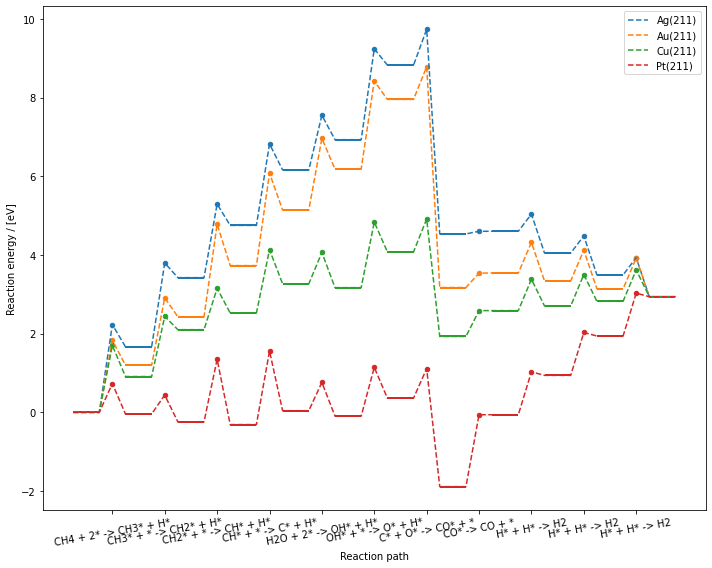

[0, 0, 0.73, -0.04, -0.04, 0.44, -0.24000000000000002, -0.24000000000000002, 1.35, -0.31000000000000005, -0.31000000000000005, 1.56, 0.04299999999999993, 0.04299999999999993, 0.7619999999999999, -0.09500000000000008, -0.09500000000000008, 1.1429999999999998, 0.36299999999999993, 0.36299999999999993, 1.113, -1.887, -1.887, -0.06000000000000005, -0.06000000000000005, -0.06000000000000005, 1.03, 0.94, 0.94, 2.0300000000000002, 1.94, 1.94, 3.0300000000000002, 2.94, 2.94]


In [85]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from ase.db import connect
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import pickle
import copy

# initial energy
start=0
# Temperature
# T=1000
# Entropy change for the reaction and for the TS
# S_de=np.array([0.0-0.002, 0.0-0.0, 0.0-0.00, 0.0-0.0, 0.0-0.002, 0.0-0.0, 0.002-0.0, 0.0-0.0, 0.002-0.0, 0.002-0.0, 0.002-0.0,])
# S_ea=np.array([0.0-0.002, 0.0-0.0, 0.0-0.00, 0.0-0.0, 0.0-0.002, 0.0-0.0, 0.0-0.0, 0.0-0.0, 0.0-0.0, 0.0-0.0, 0.0-0.0])

# Use the results from final project
pd_surf=pickle.load(open('final_project_ener_catapp.pkl','rb'))
surfaces=np.copy(pd_surf.index)
# print(surfaces)

# The reactions that will be plotted. Every second is the TS!!!
input_df={'Reactions':['CH4 + 2* -> CH3* + H*','[CH4 + 2* -> CH3* + H*]TS',
                       'CH3* + * -> CH2* + H*','[CH3* + * -> CH2* + H*]TS',
                       'CH2* + * -> CH* + H*','CH2* + * -> CH* + H*]TS',
                       'CH* + * -> C* + H*','[CH* + * -> C* + H*]TS',
                       'H2O + 2* -> OH* + H*','[H2O + 2* -> OH* + H*]TS',
                       'OH* + * -> O* + H*','[OH* + * -> O* + H*]TS',
                       'C* + O* -> CO* + *','[C* + O* -> CO* + *]TS',
                       'CO* -> CO + *','[CO* -> CO + *]TS',
                       'H* + H* -> H2','[H* + H* -> H2]TS',
                       'H* + H* -> H2','[H* + H* -> H2]TS',
                       'H* + H* -> H2','[H* + H* -> H2]TS',
                       ]}
# print(input_df['Reactions'][3])
# print(input_df['Reactions'][:3])
# print(pd_surf.keys())
# assert False

# Get the reaction energies for each surface
for s,surf in enumerate(surfaces):
    input_df[surf]=[]
    surf_keys=pd_surf.keys()
    k=0
    for r,react in enumerate(input_df['Reactions']):
        if input_df['Reactions'][r] in input_df['Reactions'][:r]: # use for repeating reaction
            i=np.where(input_df['Reactions'][r]==np.array(input_df['Reactions'][:r]))[0][0]
#             print('Ea:', i, input_df[surf][i])
#             assert False
            input_df[surf].append(input_df[surf][i])
        else:  # get reaction energies and activation energies
#             print(surf_keys[k])
#             print('pd_surf:', pd_surf[surf_keys[k]])
#             print('pd_surf:', pd_surf[surf_keys[k]][s])
#             print('============')
#             assert False
            input_df[surf].append(pd_surf[surf_keys[k]][s])
            k+=1

# Show the energies for each surface (Same results as Problem 1.)
input_df=pd.DataFrame(input_df)
display(input_df)

# Save the energies
pickle.dump(input_df,open('final_project_energies.pkl','wb'))

Reactions=copy.deepcopy(input_df['Reactions'])
# Add the entropy change
# for key in input_df:
#     if key!='Reactions':
#         data=np.array(input_df[key])
#         data[::2]=data[::2]-T*S_de
#         data[1::2]=data[1::2]-T*S_ea
#         max_ea=np.array([[0]*len(data[::2]),data[::2],data[1::2]])
#         data[1::2]=np.max(max_ea,axis=0)
#         input_df[key]=data

# Show the free energies for each surface  
# input_df=pd.DataFrame(input_df)
# display(input_df)
# Save the free energies
# pickle.dump(input_df,open('final_project_free.pkl','wb'))
        
def energy_diagram_data(DE,Ea,start):
    'Convert the data so it can be used for the energy diagram'
    energy=start
    x=[]
    E=[]
    x_without=[]
    E_without=[]
    for i in range(len(DE)):
        x.extend([2*i,2*i+1])
        x_without.extend([2*i,2*i+1])
        E.extend([energy,energy])
        E_without.extend([energy])
        xin=2*i+1.5
        Ein=Ea[i]+energy
        x.append(xin)
        E.append(Ein)
        energy+=DE[i]
    x.extend([2*i+2,2*i+3])
    x_without.extend([2*i+2,2*i+3])
    E.extend([energy,energy])
    E_without.extend([energy])
    return x,E,x_without,E_without

def energy_diagram_plot(input_df,start=0,ylabel='Reaction energy',rotation=10):
    'Plot the energy diagram from the input data'
    plt.figure(figsize=(10,8))
    for key in input_df:
#         print(key)
#         print(input_df[key][::2]) # get one value each 2 lines
        if key=='Reactions':
            xticks=[2*i+1.5 for i in range(len(input_df[key][::2]))]
            plt.xticks(xticks,input_df[key][::2],rotation=rotation)
        else:
#             print(input_df[key])
            DE=input_df[key][::2].tolist()
            Ea=input_df[key][1::2].tolist()
            x,E,x_without,E_without=energy_diagram_data(DE,Ea,start)
#             print(x,E,x_without,E_without)
            p=plt.plot(x,E,label=key,linestyle='--')
            color=p[0].get_color()
            plt.scatter(x[2::3],E[2::3],color=color,s=20)
            plt.hlines(E_without,x_without[::2],x_without[1::2],color=color,linewidth=2)
    plt.xlabel('Reaction path')
    plt.ylabel(ylabel)
    plt.legend(bbox_to_anchor=(1.0,1.0))
    plt.tight_layout()
    plt.show()
    print(E)
    pass
    
    
energy_diagram_plot(input_df,start=start,ylabel='Reaction energy / [eV]') 


['Ag(211)' 'Au(211)' 'Cu(211)' 'Pt(211)']


,Reactions,Ag(211),Au(211),Cu(211),Pt(211)
0,CH4 + 2* -> CH3* + H*,3.667,3.200,2.911,1.960
1,[CH4 + 2* -> CH3* + H*]TS,4.230,3.830,3.700,2.730
2,CH3* + * -> CH2* + H*,1.757,1.230,1.191,-0.200
3,[CH3* + * -> CH2* + H*]TS,2.130,1.710,1.530,0.480
4,CH2* + * -> CH* + H*,1.327,1.300,0.421,-0.070
5,CH2* + * -> CH* + H*]TS,1.870,2.350,1.050,1.590
6,CH* + * -> C* + H*,1.410,1.413,0.744,0.353
7,[CH* + * -> C* + H*]TS,2.070,2.350,1.610,1.870
8,H2O + 2* -> OH* + H*,2.769,3.039,1.903,1.862
9,[H2O + 2* -> OH* + H*]TS,3.389,3.820,2.798,2.719


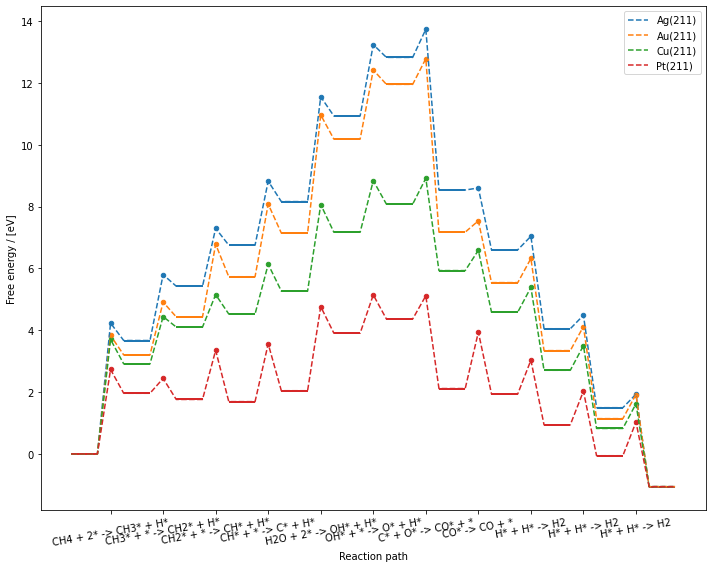

In [86]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from ase.db import connect
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import pickle
import copy

# initial energy
start=0
# Temperature
T=1000
# Entropy change for the reaction and for the TS
S_de=np.array([0.0-0.002, 0.0-0.0, 0.0-0.00, 0.0-0.0, 0.0-0.002, 0.0-0.0, 0.0-0.0, 0.002-0.0, 0.002-0.0, 0.002-0.0, 0.002-0.0,])
S_ea=np.array([0.0-0.002, 0.0-0.0, 0.0-0.00, 0.0-0.0, 0.0-0.002, 0.0-0.0, 0.0-0.0, 0.0-0.0, 0.0-0.0, 0.0-0.0, 0.0-0.0])

# Use the results from final project
pd_surf=pickle.load(open('final_project_ener_catapp.pkl','rb'))
surfaces=np.copy(pd_surf.index)
print(surfaces)

# The reactions that will be plotted. Every second is the TS!!!
input_df={'Reactions':['CH4 + 2* -> CH3* + H*','[CH4 + 2* -> CH3* + H*]TS',
                       'CH3* + * -> CH2* + H*','[CH3* + * -> CH2* + H*]TS',
                       'CH2* + * -> CH* + H*','CH2* + * -> CH* + H*]TS',
                       'CH* + * -> C* + H*','[CH* + * -> C* + H*]TS',
                       'H2O + 2* -> OH* + H*','[H2O + 2* -> OH* + H*]TS',
                       'OH* + * -> O* + H*','[OH* + * -> O* + H*]TS',
                       'C* + O* -> CO* + *','[C* + O* -> CO* + *]TS',
                       'CO* -> CO + *','[CO* -> CO + *]TS',
                       'H* + H* -> H2','[H* + H* -> H2]TS',
                       'H* + H* -> H2','[H* + H* -> H2]TS',
                       'H* + H* -> H2','[H* + H* -> H2]TS',
                       ]}

# Get the reaction energies for each surface
for s,surf in enumerate(surfaces):
    input_df[surf]=[]
    surf_keys=pd_surf.keys()
    k=0
    for r,react in enumerate(input_df['Reactions']):
        if input_df['Reactions'][r] in input_df['Reactions'][:r]: 
            i=np.where(input_df['Reactions'][r]==np.array(input_df['Reactions'][:r]))[0][0]
            input_df[surf].append(input_df[surf][i])
        else:  # get reaction energies and activation energies
            input_df[surf].append(pd_surf[surf_keys[k]][s])
            k+=1

# Show the energies for each surface (Same results as Problem 1.)
input_df=pd.DataFrame(input_df)
# display(input_df)

# Save the energies
# pickle.dump(input_df,open('final_project_energies.pkl','wb'))

Reactions=copy.deepcopy(input_df['Reactions'])
# Add the entropy change
for key in input_df:
    if key!='Reactions':
        data=np.array(input_df[key])
        data[::2]=data[::2]-T*S_de
        data[1::2]=data[1::2]-T*S_ea
        max_ea=np.array([[0]*len(data[::2]),data[::2],data[1::2]])
        data[1::2]=np.max(max_ea,axis=0)
        input_df[key]=data

# Show the free energies for each surface  
input_df=pd.DataFrame(input_df)
display(input_df)
# Save the free energies
pickle.dump(input_df,open('final_project_free.pkl','wb'))
        
def energy_diagram_data(DE,Ea,start):
    'Convert the data so it can be used for the energy diagram'
    energy=start
    x=[]
    E=[]
    x_without=[]
    E_without=[]
    for i in range(len(DE)):
        x.extend([2*i,2*i+1])
        x_without.extend([2*i,2*i+1])
        E.extend([energy,energy])
        E_without.extend([energy])
        xin=2*i+1.5
        Ein=Ea[i]+energy
        x.append(xin)
        E.append(Ein)
        energy+=DE[i]
    x.extend([2*i+2,2*i+3])
    x_without.extend([2*i+2,2*i+3])
    E.extend([energy,energy])
    E_without.extend([energy])
    return x,E,x_without,E_without

def energy_diagram_plot(input_df,start=0,ylabel='Reaction energy',rotation=10):
    'Plot the energy diagram from the input data'
    plt.figure(figsize=(10,8))
    for key in input_df:
        if key=='Reactions':
            xticks=[2*i+1.5 for i in range(len(input_df[key][::2]))]
            plt.xticks(xticks,input_df[key][::2],rotation=rotation)
        else:
            DE=input_df[key][::2].tolist()
            Ea=input_df[key][1::2].tolist()
            x,E,x_without,E_without=energy_diagram_data(DE,Ea,start)
            p=plt.plot(x,E,label=key,linestyle='--')
            color=p[0].get_color()
            plt.scatter(x[2::3],E[2::3],color=color,s=20)
            plt.hlines(E_without,x_without[::2],x_without[1::2],color=color,linewidth=2)
    plt.xlabel('Reaction path')
    plt.ylabel(ylabel)
    plt.legend(bbox_to_anchor=(1.0,1.0))
    plt.tight_layout()
    plt.show()
#     print(E)
    pass
    
    
energy_diagram_plot(input_df,start=start,ylabel='Free energy / [eV]') 


# Kinetic calculations

### Use the quasi-equilibrium approximation in order to obtain an expression for the reaction rate as a function of rate/equilibrium constants and pressures.

The following holds:
\begin{eqnarray}
    R_1 = & k_{1}\theta_{*}^2P_{CH_{4}}-k_{-1}\theta_{CH_{3}}\theta_{H} \nonumber \\ 
    R_2 = 0 = & k_{2}\theta_{CH_{3}}\theta_{*} - k_{-2}\theta_{CH_{2}}\theta_{H} \nonumber \\ 
    R_3 = 0 = & k_{3}\theta_{CH_{2}}\theta_{*} - k_{-3}\theta_{CH}\theta_{H} \nonumber \\ 
    R_4 = 0 = & k_{4}\theta_{CH}\theta_{*} - k_{-4}\theta_{C}\theta_{H} \nonumber \\ 
    R_5 = 0 = & k_{5}\theta_{*}^2 P_{H_{2}O} - k_{-5}\theta_{OH}\theta_{H} \nonumber \\ 
    R_6 = 0 = & k_{6}\theta_*\theta_{OH} - k_{-6}\theta_{O}\theta_{H} \nonumber \\
    R_7 = & k_{7}\theta_{C}\theta_{O} - k_{-7}\theta_{CO}\theta_{*} \nonumber \\
    R_8 = 0 = & k_{8}\theta_{CO} - k_{-8}\theta_{*}P_{CO} \nonumber  \\
    R_9 = 0 = & k_{9}\theta_{H}^2 - k_{-9}\theta_{*}P_{H_{2}} \nonumber  \\
\end{eqnarray}
The quasi-equilibriated reactions 2, 3, 4, 5, 6, 8 and 9 give:
\begin{eqnarray}
    \theta_{CH_{3}}= \frac{\theta_{C} P_{H_2}^{\frac{3}{2}}}{K_{2} K_{3} K_{4} K_{9}^{\frac{3}{2}}} \nonumber  \\
    \theta_{CH_{2}}= \frac{\theta_{C} P_{H_2}}{K_{3} K_{4} K_{9}} \nonumber  \\
    \theta_{CH}= \frac{\theta_{C} P_{H_2}^{\frac{1}{2}}}{K_{4} K_{9}^{\frac{1}{2}}} \nonumber  \\
    \theta_{O}= \frac{K_{5} K_{6} K_{9} \theta_{*} P_{H_{2}O}}{P_{H_2}} \nonumber  \\
    \theta_{OH}= \frac{K_{5} K_{9}^{\frac{1}{2}} \theta_{*} P_{H_{2}O}}{P_{H_2}^\frac{1}{2}} \nonumber  \\
    \theta_{CO}= \frac{P_{CO} \theta_{*}}{K_{8}} \nonumber  \\
    \theta_{H}= \frac{P_{H_2}^{\frac{1}{2}} \theta_{*}}{K_{9}^\frac{1}{2}} \nonumber  \\
\end{eqnarray}

If step 1 is limiting:
\begin{eqnarray}
    R_{7} = 0  \nonumber  \\
    \theta_{C}= \frac{P_{H_2} P_{CO} \theta_{*}}{K_{5} K_{6} K_{7} K_{8} K_{9} P_{H_{2}O}} \nonumber  \\
    1 = \theta_{*}+\theta_{CH_{3}}+\theta_{CH_{2}}+\theta_{CH}+\theta_{O}+\theta_{OH}+\theta_{CO}+\theta_{H}+\theta_{C} \nonumber \\
    \theta_* = \frac{1}{1 + \frac{P_{H_2}^{\frac{5}{2}} P_{CO}}{K_{2} K_{3} K_{4} K_{5} K_{6} K_{7} K_{8} K_{9}^{\frac{5}{2}} P_{H_{2}O}} + \frac{P_{H_2}^2 P_{CO}}{K_{3} K_{4} K_{5} K_{6} K_{7} K_{8} K_{9}^2 P_{H_{2}O}} + \frac{P_{H_2}^{\frac{3}{2}} P_{CO}}{K_{4} K_{5} K_{6} K_{7} K_{8} K_{9}^{\frac{3}{2}} P_{H_{2}O}} + \frac{K_{5} K_{6} K_{9} P_{H_{2}O}}{P_{H_2}} + \frac{K_{5} K_{9}^{\frac{1}{2}} P_{H_{2}O}}{P_{H_2}^\frac{1}{2}} + \frac{P_{CO}}{K_{8}} + \frac{P_{H_2}^{\frac{1}{2}}}{K_{9}^\frac{1}{2}} + \frac{P_{H_2} P_{CO}}{K_{5} K_{6} K_{7} K_{8} K_{9} P_{H_{2}O}}} \nonumber \\
    R = \frac{ k_{1}P_{CH_{4}} - k_{-1} \frac{P_{H_2}^{3} P_{CO}}{K_{2} K_{3} K_{4} K_{5} K_{6} K_{7} K_{8} K_{9}^{3} P_{H_{2}O}} }  { \left(1 + \frac{P_{H_2}^{\frac{5}{2}} P_{CO}}{K_{2} K_{3} K_{4} K_{5} K_{6} K_{7} K_{8} K_{9}^{\frac{5}{2}} P_{H_{2}O}} + \frac{P_{H_2}^2 P_{CO}}{K_{3} K_{4} K_{5} K_{6} K_{7} K_{8} K_{9}^2 P_{H_{2}O}} + \frac{P_{H_2}^{\frac{3}{2}} P_{CO}}{K_{4} K_{5} K_{6} K_{7} K_{8} K_{9}^{\frac{3}{2}} P_{H_{2}O}} + \frac{K_{5} K_{6} K_{9} P_{H_{2}O}}{P_{H_2}} + \frac{K_{5} K_{9}^{\frac{1}{2}} P_{H_{2}O}}{P_{H_2}^\frac{1}{2}} + \frac{P_{CO}}{K_{8}} + \frac{P_{H_2}^{\frac{1}{2}}}{K_{9}^\frac{1}{2}} + \frac{P_{H_2} P_{CO}}{K_{5} K_{6} K_{7} K_{8} K_{9} P_{H_{2}O}}\right)^2 }
\end{eqnarray}

If step 7 is limiting:
\begin{eqnarray}
    R_{1} = 0  \nonumber  \\
    \theta_{C}= \frac{K_{1} K_{2} K_{3} K_{4} K_{9}^2 P_{CH_4} \theta_{*}}{P_{H_2}^2} \nonumber  \\
    1 = \theta_{*}+\theta_{CH_{3}}+\theta_{CH_{2}}+\theta_{CH}+\theta_{O}+\theta_{OH}+\theta_{CO}+\theta_{H}+\theta_{C} \nonumber \\
    \theta_* = \frac{1}{1 + \frac{K_{1} P_{CH_4} K_{9}^{\frac{1}{2}}}{P_{H_2}^{\frac{1}{2}}} + \frac{K_{1} K_{2} K_{9} P_{CH_4}}{P_{H_2}} + \frac{K_{1} K_{2} K_{3} K_{9}^{\frac{3}{2}} P_{CH_4}}{P_{H_2}^{\frac{3}{2}}} + \frac{K_{5} K_{6} K_{9} P_{H_{2}O}}{P_{H_2}} + \frac{K_{5} K_{9}^{\frac{1}{2}} P_{H_{2}O}}{P_{H_2}^\frac{1}{2}} + \frac{P_{CO}}{K_{8}} + \frac{P_{H_2}^{\frac{1}{2}}}{K_{9}^\frac{1}{2}} + \frac{K_{1} K_{2} K_{3} K_{4} K_{9}^2 P_{CH_4}}{P_{H_2}^2}} \nonumber \\
    R = \frac{ k_{7} \frac{K_{1} K_{2} K_{3} K_{4} K_{5} K_{6} K_{9}^3 P_{CH_4} P_{H_{2}O}}{P_{H_2}^3} - k_{-7} \frac{P_{CO}}{K_{8}} }  { \left(1 + \frac{K_{1} P_{CH_4} K_{9}^{\frac{1}{2}}}{P_{H_2}^{\frac{1}{2}}} + \frac{K_{1} K_{2} K_{9} P_{CH_4}}{P_{H_2}} + \frac{K_{1} K_{2} K_{3} K_{9}^{\frac{3}{2}} P_{CH_4}}{P_{H_2}^{\frac{3}{2}}} + \frac{K_{5} K_{6} K_{9} P_{H_{2}O}}{P_{H_2}} + \frac{K_{5} K_{9}^{\frac{1}{2}} P_{H_{2}O}}{P_{H_2}^\frac{1}{2}} + \frac{P_{CO}}{K_{8}} + \frac{P_{H_2}^{\frac{1}{2}}}{K_{9}^\frac{1}{2}} + \frac{K_{1} K_{2} K_{3} K_{4} K_{9}^2 P_{CH_4}}{P_{H_2}^2}\right)^2 }
\end{eqnarray}


# Relative energies solved by hand

11 species and 4 gas (actually more species):
\begin{eqnarray}
    E_{CH_{4}} =& 0 \nonumber \\
    E_{H_2} =& 0 \nonumber \\
    E_{H_{2}O} =& 0 \nonumber \\
    E_{CO} = \Delta E_{rxn} - 3 E_{H_{2}} + E_{CH_{4}} + E_{H_{2}O} =& 2.94 \nonumber \\
    E_{CH_3*} =& \Delta E_1 - E_{H*} + E_{CH_4} \nonumber \\
    E_{CH_2*} =& \Delta E_2 - E_{H*} + E_{CH_{3}*} \nonumber \\
    E_{CH*} =& \Delta E_3 - E_{H*} + E_{CH_{2}*} \nonumber \\
    E_{C*} =& \Delta E_4 - E_{H*} + E_{CH*} \nonumber \\
    E_{OH*} =& \Delta E_5 - E_{H*} + E_{H_{2}O} \nonumber \\
    E_{O*} =& \Delta E_6 - E_{H*} + E_{OH*} \nonumber \\
    E_{CO*} =& \Delta E_7 + E_{C*} + E_{O*} \nonumber \\
    E_{CO*} =& E_{CO} - \Delta E_8 \nonumber \\
    E_{H*} =& \frac{1}{2}(E_{H_{2}} - \Delta E_9) \nonumber \\
    E_{CH_{3}-H*} =& \Delta E_{a,1} + E_{CH_{4}} \nonumber \\
    E_{O-H*} =& \Delta E_{a,5} + E_{O*} + E_{H*} \nonumber
\end{eqnarray}

Simplify:
\begin{eqnarray}
    E_{CH_{4}} =& 0 \nonumber \\
    E_{H_2} =& 0 \nonumber \\
    E_{H_{2}O} =& 0 \nonumber \\
    E_{CO} =& 2.94 \nonumber \\
    E_{CH_3*} =& \Delta E_1 + \frac{1}{2}\Delta E_9 \nonumber \\
    E_{CH_2*} =& \Delta E_1 + \Delta E_2  + \Delta E_9 \nonumber \\
    E_{CH*} =& \Delta E_1 + \Delta E_2 + \Delta E_3 + \frac{3}{2}\Delta E_9 \nonumber \\
    E_{C*} =& \Delta E_1 + \Delta E_2 + \Delta E_3 + \Delta E_4 + 2\Delta E_9 \nonumber \\
    E_{OH*} =& \Delta E_5 + \frac{1}{2}\Delta E_9 \nonumber \\
    E_{O*} =& \Delta E_5 + \Delta E_6 + \Delta E_9 \nonumber \\
    E_{CO*} =& E_{CO} - \Delta E_8 \nonumber \\
    E_{H*} =& - \frac{1}{2}\Delta E_9 \nonumber \\
    E_{CH_{3}-H*} =& \Delta E_{a,1} \nonumber \\
    E_{C-O*} =& \Delta E_{a,7} + E_{CO} - \Delta E_7 - \Delta E_8 \nonumber
\end{eqnarray}

# Relative energies

In [87]:
# All compounds that the energy is obtained for
compounds=['CH4','CH3*','H*','CH3-H*','CH2*','CH2-H*','CH*','CH-H*','C*','C-H*','H2O','OH*','OH-H*','O*','O-H*','CO*','C-O*',
           'CO','[CO*]TS','H2','H-H*']

# Reactants and products for all elementary reactions including TS formation
products=[['CH3*','H*'],['CH3-H*'],['CH2*','H*'],['CH2-H*'],['CH*','H*'],['CH-H*'],['C*','H*'],['C-H*'],['OH*','H*'],['OH-H*'],
          ['O*','H*'],['O-H*'],['CO*'],['C-O*'],['CO'],['[CO*]TS'],['H2'],['H-H*']]
reactants=[['CH4'],['CH4'],['CH3*'],['CH3*'],['CH2*'],['CH2*'],['CH*'],['CH*'],['H2O'],['H2O'],['OH*'],['OH*'],
           ['C*','O*'],['C*','O*'],['CO*'],['CO*'],['H*','H*'],['H*','H*']]
print(len(compounds))
print(len(products))
print(len(reactants))

energy_df=pickle.load(open('final_project_ener_catapp.pkl','rb'))
display(energy_df)
# The surfaces
metals=copy.deepcopy(energy_df.index)

# The descriptor used
descriptor='CO*'

def comp_energies_surf(compounds,reactants,products,pd_ener,ref,ref_txt,surfaces):
    'Compare energies by one reference for multiple surfaces'
    react=reactants+ref['Reactants']
    prod=products+ref['Products']
    pd_dict={'Surface':[],'Ref':[ref_txt]*len(surfaces)}
    for s,surf in enumerate(surfaces):
        energies=[pd_ener[key][s] for key in pd_ener.keys()]
        ener=energies+ref['Energies']
        coef_matrix=np.zeros((len(prod),len(compounds)))
        for row in range(len(coef_matrix)):
            for col in range(len(coef_matrix[0])):
                if compounds[col] in prod[row]:
                    coef_matrix[row,col]+=prod[row].count(compounds[col])
                if compounds[col] in react[row]:
                    coef_matrix[row,col]-=react[row].count(compounds[col])
        #coef_matrix[range(len(coef_matrix)),range(len(coef_matrix))]+=1e-10
        comp_energy=np.linalg.solve(coef_matrix,ener)
        pd_dict['Surface'].append(surf)
        for e in range(len(compounds)):
            if compounds[e] not in pd_dict:
                pd_dict[compounds[e]]=[]
            pd_dict[compounds[e]].append(round(comp_energy[e],2))
    return pd.DataFrame(pd_dict)

# Reference A (CO=0 eV , O2=0 eV)
ref={'Reactants':[[],[],[]],'Products':[['CH4'],['H2'],['H2O']],'Energies':[0,0,0]}
# Get the energies of all compounds compared to Reference A
pd_surf=comp_energies_surf(compounds,reactants,products,energy_df,ref,'CH4=0 eV & H2=0 eV & H2O=0 eV',metals)

# Make a linear combination descriptor of NO* and O*
# pd_surf['NO*+O*']=pd_surf['NO*']+pd_surf['O*']

display(pd_surf)
pickle.dump(pd_surf,open('final_project_compound_energies.pkl','wb'))


21
18
18


CH4 -> H* + CH3*       CH3* -> H* + CH2*       CH2* -> H* + CH*        \
                  E_diff    Ea            E_diff    Ea           E_diff    Ea   
Surface                                                                         
Ag(211)            1.667  2.23             1.757  2.13            1.327  1.87   
Au(211)            1.200  1.83             1.230  1.71            1.300  2.35   
Cu(211)            0.911  1.70             1.191  1.53            0.421  1.05   
Pt(211)           -0.040  0.73            -0.200  0.48           -0.070  1.59   

        CH* -> H* + C*       H2O -> H* + OH*        OH* -> O* + H*         \
                E_diff    Ea          E_diff     Ea         E_diff     Ea   
Surface                                                                     
Ag(211)          1.410  2.07           0.769  1.389          1.895  2.309   
Au(211)          1.413  2.35           1.039  1.820          1.771  2.236   
Cu(211)          0.744  1.61          -0.097  0.798          0.909  1.666   
Pt(211)          0.353  1.87          -0.138  0.719          0.458  1.238   

        C* + O* -> CO*        CO* -> CO + *        H* + H* -> H2         
                E_diff     Ea        E_diff     Ea        E_diff     Ea  
Surface                                                                  
Ag(211)          -4.29  0.910         0.067  0.067        -0.554  0.436  
Au(211)          -4.78  0.830         0.367  0.367        -0.200  0.780  
Cu(211)          -2.15  0.836         0.657  0.657         0.118  0.798  
Pt(211)          -2.25  0.750         1.827  1.827         1.000  1.090

,Surface,Ref,CH4,CH3*,H*,CH3-H*,CH2*,CH2-H*,CH*,CH-H*,...,OH*,OH-H*,O*,O-H*,CO*,C-O*,CO,[CO*]TS,H2,H-H*
0,Ag(211),CH4=0 eV & H2=0 eV & H2O=0 eV,0.0,1.39,0.28,2.23,2.87,3.52,3.92,4.74,...,0.49,1.39,2.11,2.80,2.87,8.07,2.94,2.94,0.0,0.99
1,Au(211),CH4=0 eV & H2=0 eV & H2O=0 eV,-0.0,1.10,0.10,1.83,2.23,2.81,3.43,4.58,...,0.94,1.82,2.61,3.18,2.57,8.18,2.94,2.94,0.0,0.98
2,Cu(211),CH4=0 eV & H2=0 eV & H2O=0 eV,-0.0,0.97,-0.06,1.70,2.22,2.50,2.70,3.27,...,-0.04,0.80,0.93,1.63,2.28,5.27,2.94,2.94,0.0,0.68
3,Pt(211),CH4=0 eV & H2=0 eV & H2O=0 eV,0.0,0.46,-0.50,0.73,0.76,0.94,1.19,2.35,...,0.36,0.72,1.32,1.60,1.11,4.11,2.94,2.94,0.0,0.09


# Scaling relations

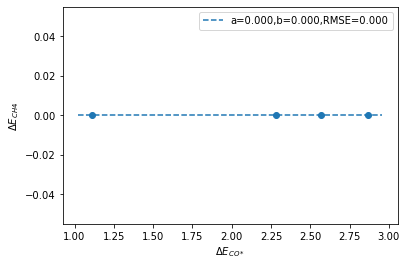

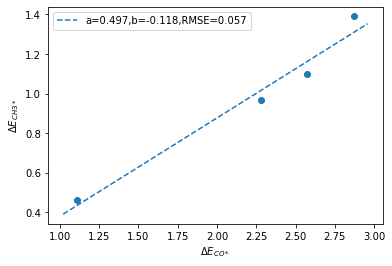

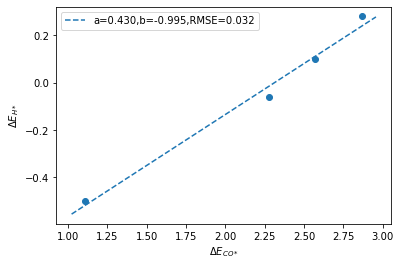

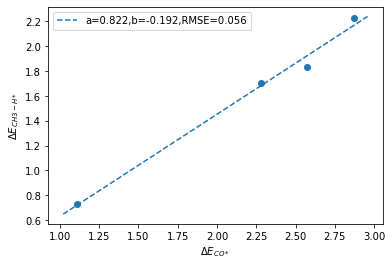

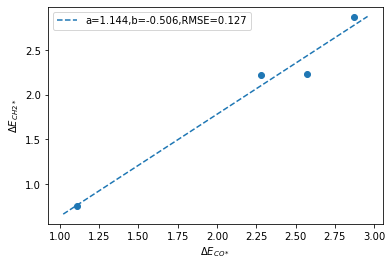

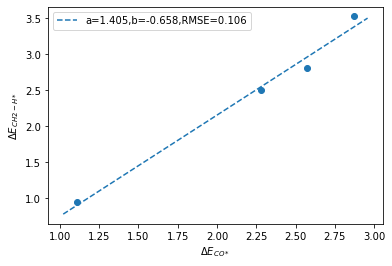

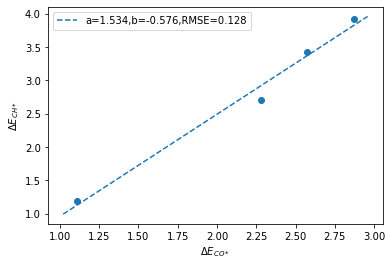

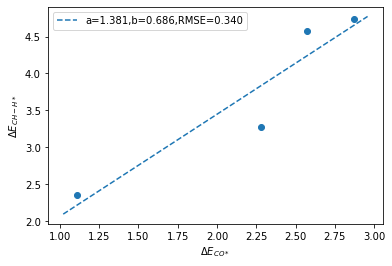

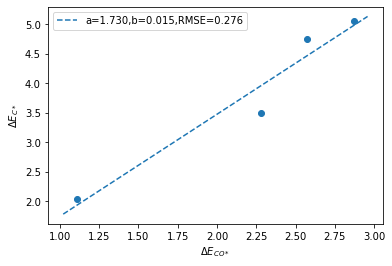

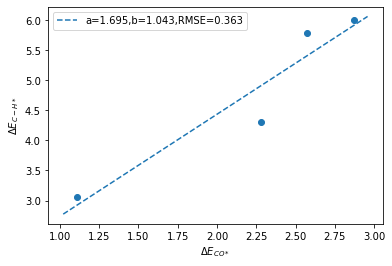

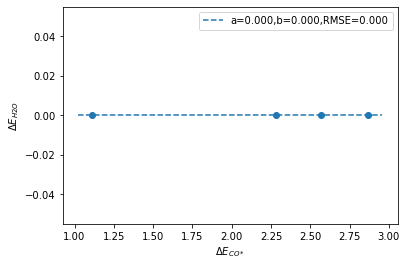

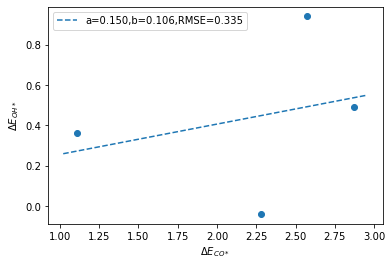

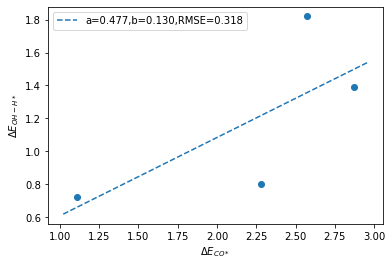

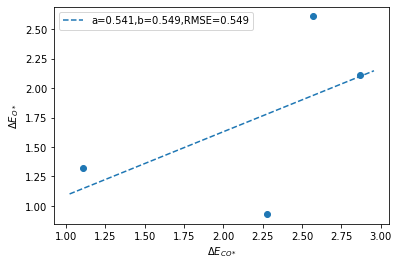

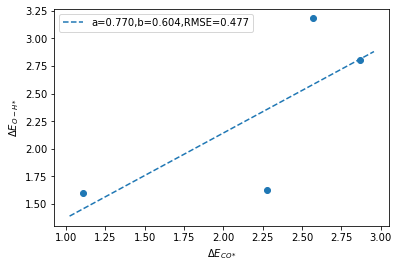

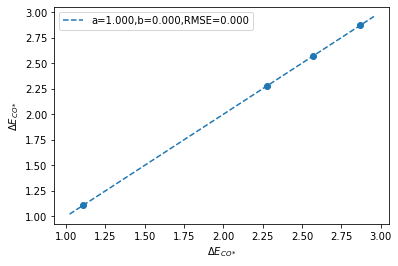

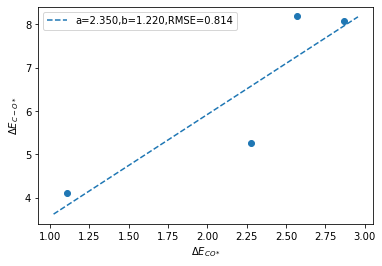

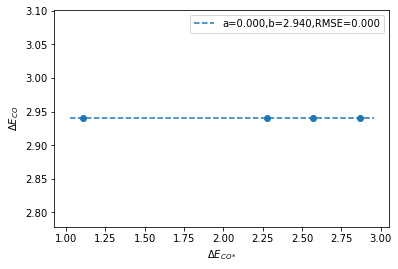

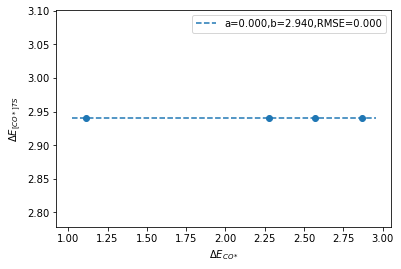

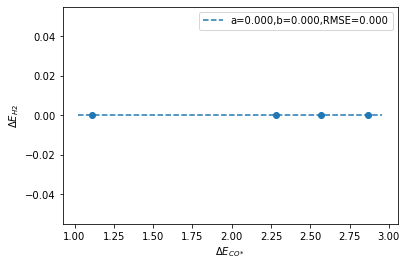

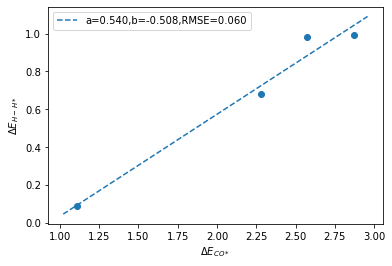

,Compounds,a,b,RMSE
0,CH4,0.000000e+00,0.000000e+00,0.000000e+00
1,CH3*,4.972262e-01,-1.176269e-01,5.680021e-02
2,H*,4.304032e-01,-9.951151e-01,3.219696e-02
3,CH3-H*,8.217772e-01,-1.915731e-01,5.603304e-02
4,CH2*,1.144109e+00,-5.056208e-01,1.265972e-01
5,CH2-H*,1.404562e+00,-6.580697e-01,1.062485e-01
6,CH*,1.533699e+00,-5.756415e-01,1.283036e-01
7,CH-H*,1.381093e+00,6.862361e-01,3.402759e-01
8,C*,1.729548e+00,1.452298e-02,2.759858e-01
9,C-H*,1.695294e+00,1.042639e+00,3.630865e-01


In [88]:
# The descriptor used as a linear combination of NO* and O*
descriptor='CO*'

# Compounds that are used for scaling relations
scaling_comp=['CH4','CH3*','H*','CH3-H*','CH2*','CH2-H*','CH*','CH-H*','C*','C-H*','H2O','OH*','OH-H*','O*','O-H*','CO*','C-O*',
           'CO','[CO*]TS','H2','H-H*']
# Load compound energies
pd_energy_surf=pickle.load(open('final_project_compound_energies.pkl','rb'))

# Plot the scaling relations
pd_scaling={'Compounds':[],'a':[],'b':[],'RMSE':[]}
for comp in scaling_comp:
    fig,ax=plt.subplots()
    x=pd_energy_surf[descriptor].values
    y=pd_energy_surf[comp].values
    ax.scatter(x,y)
    # Make linear fit
    a,b=np.polyfit(x,y,1) 
    x_axis=np.linspace(ax.get_xbound()[0],ax.get_xbound()[1],50)
    y_pred=a*x+b
    # Calculate root-mean-square error
    rmse=np.sqrt(np.mean((y-y_pred)**2))
    plt.plot(x_axis,a*x_axis+b,'--',label='a={:.3f},b={:.3f},RMSE={:.3f}'.format(a,b,rmse))
    ylab='$\Delta E_{'+comp+'}$'
    plt.ylabel(ylab)
    plt.xlabel('$\Delta E_{CO*}$')
    ax.legend(loc=0)
    plt.show()
    # Save linear scaling  
    pd_scaling['Compounds'].append(comp)
    pd_scaling['a'].append(a)
    pd_scaling['b'].append(b)
    pd_scaling['RMSE'].append(rmse)

pd_scaling=pd.DataFrame(pd_scaling)
display(pd_scaling)
pickle.dump(pd_scaling,open('Linear_scaling_final_project.pkl','wb'))

# Activity volcano

In [89]:
# Partial pressures
pCH4,pH2O,pH2,pCO=0.4,0.4,0.1,0.1

# Entropies for each compound
S_compound={'CH4':0.002,'CH3*':0.0,'H*':0.0,'CH3-H*':0.0,'CH2*':0.0,'CH2-H*':0.0,'CH*':0.0,'CH-H*':0.0,'C*':0.0,\
           'C-H*':0.0,'H2O':0.002,'OH*':0.0,'OH-H*':0.0,'O*':0.0,'O-H*':0.0,'CO*':0.0,'C-O*':0.0, 'CO':0.002,\
           '[CO*]TS':0.0,'H2':0.002,'H-H*':0.0}
print(len(S_compound))

# Fixed energies that are independent of the surfaces
energi_fixed={'CH4':0.00,'H2':0.00,'H2O':0.00,'CO':2.94}

# Reactants and products for all elementary reactions including TS formation
products=[['CH3*','H*'],['CH2*','H*'],['CH*','H*'],['C*','H*'],['OH*','H*'],['O*','H*'],['CO*'],['CO'],['H2']]
products_ts=[['CH3-H*'],['CH2-H*'],['CH-H*'],['C-H*'],['OH-H*'],['O-H*'],['C-O*'],['[CO*]TS'],['H-H*']]
reactants=[['CH4'],['CH3*'],['CH2*'],['CH*'],['H2O'],['OH*'],['C*','O*'],['CO*'],['H*','H*']]

# Temperature
T=1000 # K

# Boltzmann constant
kB=8.617333262145*10**(-5) # eV/K
# Planck constant
h=4.135667696*10**(-15) # eV*s

kBT=kB*T
# Prefactor in TS theory
A=kBT/h

pd_ener=pickle.load(open('final_project_compound_energies.pkl','rb'))

def free_energy(pd_ener,fixed_e,reactants,products_ts,products):
    'Calculate the free energy for each surface'
    pd_dict={'Surface':pd_ener['Surface']}
    pd_dict=pd.DataFrame(pd_dict)
#     display(pd_dict)
    for c,comp in enumerate(pd_ener.keys()):
        pd_dict[comp]=pd_ener[comp]
    
    display(pd_dict)
    # Calculate reaction free energies
    for r in range(len(reactants)):
        pd_dict['G'+str(r+1)]=np.array([0]*len(pd_dict['Surface']))
        pd_dict['Ga'+str(r+1)]=np.array([0]*len(pd_dict['Surface']))
        Grea=0
        S_change=0
        Sa_change=0
        # Calculate the enthalpies and entropies for the product 
        for prod in products[r]:
            if prod in pd_dict.keys():
                pd_dict['G'+str(r+1)]=pd_dict['G'+str(r+1)]+pd_dict[prod]
            else:
                pd_dict['G'+str(r+1)]=pd_dict['G'+str(r+1)]+np.array([0]*len(pd_dict['Surface']))
            S_change=S_change-T*S_compound[prod]
        # Calculate the enthalpies and entropies for the trainsition state 
        for prod in products_ts[r]:
            if prod in pd_dict.keys():
                pd_dict['Ga'+str(r+1)]=pd_dict['Ga'+str(r+1)]+pd_dict[prod]
            else:
                pd_dict['Ga'+str(r+1)]=pd_dict['Ga'+str(r+1)]+np.array([0]*len(pd_dict['Surface']))
            Sa_change=Sa_change-T*S_compound[prod]
        # Calculate the enthalpies and entropies for the reactants 
        for rea in reactants[r]:
            if rea in pd_dict.keys():
                Grea=Grea+pd_dict[rea]
            else:
                Grea=Grea+np.array([0]*len(pd_dict['Surface']))  
            S_change=S_change-(-T*S_compound[rea])
            Sa_change=Sa_change-(-T*S_compound[rea])
        # Calculate the enthalpy change
        pd_dict['G'+str(r+1)]=pd_dict['G'+str(r+1)]-Grea
        pd_dict['Ga'+str(r+1)]=pd_dict['Ga'+str(r+1)]-Grea
        # The activation energy is the largest energy before the entropy is taking into account
        pd_dict['Ga'+str(r+1)]=np.max(np.array([pd_dict['G'+str(r+1)],pd_dict['Ga'+str(r+1)],[0]*len(pd_dict['Surface'])]),axis=0)
        # Free energy
        pd_dict['G'+str(r+1)]=pd_dict['G'+str(r+1)]+S_change
        pd_dict['Ga'+str(r+1)]=pd_dict['Ga'+str(r+1)]+Sa_change
    pd_dict=pd.DataFrame(pd_dict)
    return pd_dict


def rate_eq(Ga,G,A,kBT):
    """Calculate the forward and backsward reaction rate 
       and the equilibrium constant from activation free energy and free energy"""
    k=A*np.exp(-Ga/kBT)
    Ga_inv=Ga-G
    kinv=A*np.exp(-Ga_inv/kBT)
    K=np.exp(-G/kBT)
    return k,kinv,K

def R1(k1,k1i,K1,K2,K3,K4,K5,K6,K7,K8,K9,pCH4,pH2O,pH2,pCO):
    'Rate of reaction 1'
    cov = 1 + ((pH2**(5/2))*pCO)/(K2*K3*K4*K5*K6*K7*K8*(K9**(5/2))*pH2O) + ((pH2**2)*pCO)/(K3*K4*K5*K6*K7*K8*(K9**2)*pH2O) + \
    ((pH2**(3/2))*pCO)/(K4*K5*K6*K7*K8*(K9**(3/2))*pH2O) + (K5*K6*K9*pH2O)/pH2 + ((K5*(K9**(1/2))*pH2O)/(pH2**(1/2))) + \
    pCO/K8 + (pH2**(1/2))/(K9**(1/2)) + (pH2*pCO)/(K5*K6*K7*K8*K9*pH2O)

    return (k1*pCH4-k1i*((pH2**2)*pCO)/(K2*K3*K4*K5*K6*K7*K8*(K9**3)*pH2O))/(cov**2)

def R7(k7,k7i,K1,K2,K3,K4,K5,K6,K7,K8,K9,pCH4,pH2O,pH2,pCO):
    'Rate of reaction 7'
    cov = 1 + (K1*pCH4*(K9**(1/2)))/(pH2**(1/2)) + (K1*K2*K9*pCH4)/pH2 + (K1*K2*K3*(K9**(3/2))*pCH4)/(pH2*(3/2)) + \
    (K5*K6*K9*pH2O)/pH2 + (K5*(K9**(1/2))*pH2O)/(pH2**(1/2)) + pCO/K8 + (pH2**(1/2))/(K9**(1/2)) + \
    (K1*K2*K3*K4*(K9**2)*pCH4)/(pH2**2)
    
    return (k7*(K1*K2*K3*K4*K5*K6*(K9**3)*pCH4*pH2O)/(pH2**3)-k7i*pCO/K8)/cov**2


def rates_surf(pd_free,descriptor,A,kBT,pressures,rates_list):
    'Calculate the rates for each surface'
    pd_rates={'Surface':pd_free['Surface'],'Descriptor':descriptor}
    rate_constants=[]
    # Rate and equilibrium constants 
    for r in range(len(reactants)):
        pd_rates['k'+str(r+1)],pd_rates['k-'+str(r+1)],pd_rates['K'+str(r+1)]=rate_eq(pd_free['Ga'+str(r+1)],pd_free['G'+str(r+1)],A,kBT)
        rate_constants.append(np.array(pd_rates['K'+str(r+1)]))
#     print(rate_constants)
    # Log10 rates
    for r in rates_list.keys():
        pd_rates['RDS'+r]=np.log10(rates_list[r](pd_rates['k'+r],pd_rates['k-'+r],*rate_constants,*pressures))
    # Reaction rate
    pd_rates['R']=np.min([pd_rates['RDS'+r] for r in rates_list.keys()],axis=0)
    
    pd_rates=pd.DataFrame(pd_rates)
    return pd_rates

rates_list={'1':R1,'7':R7}
pressures_p=[pCH4,pH2O,pH2,pCO]

pd_free_surf=free_energy(pd_ener,energi_fixed,reactants,products_ts,products)
display(pd_free_surf)

pd_rates_surf=rates_surf(pd_free_surf,pd_ener['CO*'],A,kBT,pressures_p,rates_list)
display(pd_rates_surf)
pickle.dump(pd_rates_surf,open('Rates_surface_final_project.pkl','wb'))


21


,Surface,Ref,CH4,CH3*,H*,CH3-H*,CH2*,CH2-H*,CH*,CH-H*,...,OH*,OH-H*,O*,O-H*,CO*,C-O*,CO,[CO*]TS,H2,H-H*
0,Ag(211),CH4=0 eV & H2=0 eV & H2O=0 eV,0.0,1.39,0.28,2.23,2.87,3.52,3.92,4.74,...,0.49,1.39,2.11,2.80,2.87,8.07,2.94,2.94,0.0,0.99
1,Au(211),CH4=0 eV & H2=0 eV & H2O=0 eV,-0.0,1.10,0.10,1.83,2.23,2.81,3.43,4.58,...,0.94,1.82,2.61,3.18,2.57,8.18,2.94,2.94,0.0,0.98
2,Cu(211),CH4=0 eV & H2=0 eV & H2O=0 eV,-0.0,0.97,-0.06,1.70,2.22,2.50,2.70,3.27,...,-0.04,0.80,0.93,1.63,2.28,5.27,2.94,2.94,0.0,0.68
3,Pt(211),CH4=0 eV & H2=0 eV & H2O=0 eV,0.0,0.46,-0.50,0.73,0.76,0.94,1.19,2.35,...,0.36,0.72,1.32,1.60,1.11,4.11,2.94,2.94,0.0,0.09


,Surface,Ref,CH4,CH3*,H*,CH3-H*,CH2*,CH2-H*,CH*,CH-H*,...,G5,Ga5,G6,Ga6,G7,Ga7,G8,Ga8,G9,Ga9
0,Ag(211),CH4=0 eV & H2=0 eV & H2O=0 eV,0.0,1.39,0.28,2.23,2.87,3.52,3.92,4.74,...,2.77,3.39,1.90,2.31,-4.29,0.91,-1.93,0.07,-2.56,0.43
1,Au(211),CH4=0 eV & H2=0 eV & H2O=0 eV,-0.0,1.10,0.10,1.83,2.23,2.81,3.43,4.58,...,3.04,3.82,1.77,2.24,-4.78,0.83,-1.63,0.37,-2.20,0.78
2,Cu(211),CH4=0 eV & H2=0 eV & H2O=0 eV,-0.0,0.97,-0.06,1.70,2.22,2.50,2.70,3.27,...,1.90,2.80,0.91,1.67,-2.15,0.84,-1.34,0.66,-1.88,0.80
3,Pt(211),CH4=0 eV & H2=0 eV & H2O=0 eV,0.0,0.46,-0.50,0.73,0.76,0.94,1.19,2.35,...,1.86,2.72,0.46,1.24,-2.25,0.75,-0.17,1.83,-1.00,1.09


,Surface,Descriptor,k1,k-1,K1,k2,k-2,K2,k3,k-3,...,K7,k8,k-8,K8,k9,k-9,K9,RDS1,RDS7,R
0,Ag(211),2.87,1.001303e-08,3.137267e+10,3.191641e-19,3.837954e+02,2.845177e+11,1.348933e-09,7.842275e+03,3.956827e+10,...,4.174922e+21,9.247893e+12,1734.885761,5.330548e+09,1.418152e+11,0.017778,7.976863e+12,-8.397375,-15.068506,-15.068506
1,Au(211),2.57,1.038668e-06,1.392410e+10,7.459502e-17,5.021189e+04,7.938414e+10,6.325179e-07,2.987779e+01,1.064290e+08,...,1.230665e+24,2.845177e+11,1734.885761,1.639980e+08,2.442307e+09,0.019966,1.223241e+11,-6.381464,-15.622883,-15.622883
2,Cu(211),2.28,4.695134e-06,2.174716e+09,2.158964e-15,4.054774e+05,4.029978e+11,1.006153e-06,1.064290e+08,1.392410e+10,...,6.847359e+10,9.830456e+09,1734.885761,5.666342e+06,1.936443e+09,0.648966,2.983891e+09,-5.726384,-0.957221,-5.726384
3,Pt(211),1.11,3.632727e-01,2.742825e+09,1.324448e-10,7.938414e+10,7.794317e+09,1.018487e+01,2.021063e+05,8.970062e+04,...,2.185249e+11,1.247479e+04,1734.885761,7.190553e+00,6.690661e+07,610.507278,1.095918e+05,-0.850522,2.043983,-0.850522


,Descriptor,CH4,H2,H2O,CO,CH3*,H*,CH3-H*,CH2*,CH2-H*,...,G5,Ga5,G6,Ga6,G7,Ga7,G8,Ga8,G9,Ga9
0,-3.000000,0.0,0.0,0.0,2.94,-1.609306,-2.286325,-2.656905,-3.937948,-4.871755,...,-0.631014,2.000000,-3.015528,0.000000,3.248014,3.248014,3.940000,5.940000,2.572649,4.572649
1,-2.999111,0.0,0.0,0.0,2.94,-1.608864,-2.285942,-2.656174,-3.936931,-4.870506,...,-0.630498,2.000000,-3.014799,0.000000,3.246884,3.246884,3.939111,5.939111,2.571884,4.571884
2,-2.998222,0.0,0.0,0.0,2.94,-1.608422,-2.285560,-2.655444,-3.935914,-4.869258,...,-0.629982,2.000000,-3.014069,0.000000,3.245755,3.245755,3.938222,5.938222,2.571119,4.571119
3,-2.997333,0.0,0.0,0.0,2.94,-1.607980,-2.285177,-2.654713,-3.934897,-4.868009,...,-0.629466,2.000000,-3.013339,0.000000,3.244626,3.244626,3.937333,5.937333,2.570354,4.570354
4,-2.996444,0.0,0.0,0.0,2.94,-1.607538,-2.284794,-2.653983,-3.933880,-4.866761,...,-0.628949,2.000000,-3.012609,0.000000,3.243497,3.243497,3.936444,5.936444,2.569589,4.569589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8996,4.996444,0.0,0.0,0.0,2.94,2.366736,1.155371,3.914391,5.210857,6.359744,...,4.011782,4.511776,3.549815,3.592428,-6.910524,1.054235,-4.056444,0.000000,-4.310741,0.000000
8997,4.997333,0.0,0.0,0.0,2.94,2.367178,1.155753,3.915121,5.211874,6.360993,...,4.012298,4.512199,3.550545,3.592978,-6.911654,1.054306,-4.057333,0.000000,-4.311506,0.000000
8998,4.998222,0.0,0.0,0.0,2.94,2.367620,1.156136,3.915852,5.212891,6.362241,...,4.012814,4.512623,3.551275,3.593529,-6.912783,1.054377,-4.058222,0.000000,-4.312272,0.000000
8999,4.999111,0.0,0.0,0.0,2.94,2.368062,1.156518,3.916582,5.213908,6.363490,...,4.013331,4.513047,3.552004,3.594079,-6.913912,1.054447,-4.059111,0.000000,-4.313037,0.000000


,Descriptor,k1,k-1,K1,k2,k-2,K2,k3,k-3,K3,...,K7,k8,k-8,K8,k9,k-9,K9,RDS1,RDS7,R
0,-3.000000,1.734886e+03,4.849693e-07,3.577311e+09,2.083662e+13,1.149254e-10,1.813055e+23,7.855594e+10,1.347021e-07,5.831825e+17,...,4.272992e-17,2.412931e-17,1.734886e+03,1.390830e-20,1.877968e-10,1.734886e+03,1.082474e-13,-55.582177,-34.794237,-55.582177
1,-2.999111,1.734886e+03,4.896321e-07,3.543244e+09,2.083662e+13,1.162097e-10,1.793020e+23,7.836414e+10,1.355147e-07,5.782706e+17,...,4.329354e-17,2.437949e-17,1.734886e+03,1.405251e-20,1.894717e-10,1.734886e+03,1.092128e-13,-55.566680,-34.783221,-55.566680
2,-2.998222,1.734886e+03,4.943396e-07,3.509502e+09,2.083662e+13,1.175082e-10,1.773205e+23,7.817281e+10,1.363321e-07,5.734000e+17,...,4.386460e-17,2.463227e-17,1.734886e+03,1.419821e-20,1.911616e-10,1.734886e+03,1.101869e-13,-55.551184,-34.772204,-55.551184
3,-2.997333,1.734886e+03,4.990925e-07,3.476081e+09,2.083662e+13,1.188213e-10,1.753610e+23,7.798195e+10,1.371544e-07,5.685705e+17,...,4.444319e-17,2.488767e-17,1.734886e+03,1.434542e-20,1.928666e-10,1.734886e+03,1.111696e-13,-55.535688,-34.761188,-55.535688
4,-2.996444,1.734886e+03,5.038910e-07,3.442978e+09,2.083662e+13,1.201490e-10,1.734231e+23,7.779155e+10,1.379817e-07,5.637816e+17,...,4.502942e-17,2.514572e-17,1.734886e+03,1.449416e-20,1.945867e-10,1.734886e+03,1.121611e-13,-55.520192,-34.750172,-55.520192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8996,4.996444,3.247948e-17,2.196866e+11,1.478446e-28,1.453047e-07,2.083662e+13,6.973527e-21,1.093052e-02,2.083662e+13,5.245824e-16,...,6.722183e+34,2.083662e+13,7.503209e-08,2.777028e+20,2.083662e+13,3.923262e-09,5.311045e+21,-16.886331,-39.719090,-39.719090
8997,4.997333,3.220533e-17,2.199266e+11,1.464367e-28,1.436990e-07,2.083662e+13,6.896464e-21,1.083846e-02,2.083662e+13,5.201640e-16,...,6.810852e+34,2.083662e+13,7.426210e-08,2.805821e+20,2.083662e+13,3.888580e-09,5.358413e+21,-16.890012,-39.729617,-39.729617
8998,4.998222,3.193349e-17,2.201669e+11,1.450422e-28,1.421110e-07,2.083662e+13,6.820253e-21,1.074717e-02,2.083662e+13,5.157829e-16,...,6.900689e+34,2.083662e+13,7.350001e-08,2.834914e+20,2.083662e+13,3.854205e-09,5.406204e+21,-16.893694,-39.740144,-39.740144
8999,4.999111,3.166394e-17,2.204074e+11,1.436610e-28,1.405406e-07,2.083662e+13,6.744883e-21,1.065665e-02,2.083662e+13,5.114386e-16,...,6.991712e+34,2.083662e+13,7.274575e-08,2.864307e+20,2.083662e+13,3.820134e-09,5.454422e+21,-16.897375,-39.750671,-39.750671


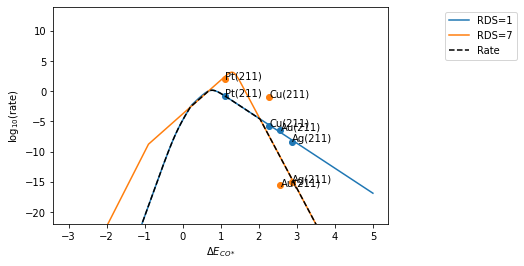

In [95]:
# The descriptor CO* range
descriptor=np.linspace(-3,5,9001)


def free_energy_descriptor(descriptor,pd_scaling,fixed_e,reactants,products_ts,products):
    'Calculate the free energy from a descriptor with linear relations'
    # Calculate enthalpies
    pd_dict={'Descriptor':descriptor}
    # Use the fixed energies
    for comp in fixed_e.keys():
        pd_dict[comp]=np.array([fixed_e[comp]]*len(descriptor))
    # Calculate O*, CO*, O-O* and O-CO* from the linear scaling relations
    for c,comp in enumerate(pd_scaling['Compounds']):
        pd_dict[comp]=pd_scaling['a'][c]*descriptor+pd_scaling['b'][c]
    # Calculate reaction free energies
    for r in range(len(reactants)):
        pd_dict['G'+str(r+1)]=np.array([0]*len(descriptor))
        pd_dict['Ga'+str(r+1)]=np.array([0]*len(descriptor))
        Grea=0
        S_change=0
        Sa_change=0
        # Calculate the enthalpies and entropies for the product 
        for prod in products[r]:
            if prod in pd_dict.keys():
                pd_dict['G'+str(r+1)]=pd_dict['G'+str(r+1)]+pd_dict[prod]
            else:
                pd_dict['G'+str(r+1)]=pd_dict['G'+str(r+1)]+np.array([0]*len(descriptor))
            S_change=S_change-T*S_compound[prod]
        # Calculate the enthalpies and entropies for the trainsition state 
        for prod in products_ts[r]:
            if prod in pd_dict.keys():
                pd_dict['Ga'+str(r+1)]=pd_dict['Ga'+str(r+1)]+pd_dict[prod]
            else:
                pd_dict['Ga'+str(r+1)]=pd_dict['Ga'+str(r+1)]+np.array([0]*len(descriptor))
            Sa_change=Sa_change-T*S_compound[prod]
        # Calculate the enthalpies and entropies for the reactants 
        for rea in reactants[r]:
            if rea in pd_dict.keys():
                Grea=Grea+pd_dict[rea]
            else:
                Grea=Grea+np.array([0]*len(descriptor))  
            S_change=S_change-(-T*S_compound[rea])
            Sa_change=Sa_change-(-T*S_compound[rea])
        # Calculate the enthalpy change
        pd_dict['G'+str(r+1)]=pd_dict['G'+str(r+1)]-Grea
        pd_dict['Ga'+str(r+1)]=pd_dict['Ga'+str(r+1)]-Grea
        # The activation energy is the largest energy before the entropy is taking into account
        pd_dict['Ga'+str(r+1)]=np.max(np.array([pd_dict['G'+str(r+1)],pd_dict['Ga'+str(r+1)],[0]*len(descriptor)]),axis=0)
        # Free energy
        pd_dict['G'+str(r+1)]=pd_dict['G'+str(r+1)]+S_change
        pd_dict['Ga'+str(r+1)]=pd_dict['Ga'+str(r+1)]+Sa_change
        # Important extra line so that the activation free energy is the largest
        #pd_dict['Ga'+str(r+1)]=np.max(np.array([pd_dict['G'+str(r+1)],pd_dict['Ga'+str(r+1)],[0]*len(descriptor)]),axis=0)

    pd_dict=pd.DataFrame(pd_dict)
    return pd_dict

def rates_descriptor(descriptor,pd_free,A,kBT,pressures,rates_list):
    'Calculate the rates for each descriptor value'
    pd_rates={'Descriptor':descriptor}
    rate_constants=[]
    # Rate and equilibrium constants 
    for r in range(len(reactants)):
        pd_rates['k'+str(r+1)],pd_rates['k-'+str(r+1)],pd_rates['K'+str(r+1)]=rate_eq(pd_free['Ga'+str(r+1)],pd_free['G'+str(r+1)],A,kBT)
        rate_constants.append(np.array(pd_rates['K'+str(r+1)]))
    # Log10 rates
    for r in rates_list.keys():
        pd_rates['RDS'+r]=np.log10(rates_list[r](pd_rates['k'+r],pd_rates['k-'+r],*rate_constants,*pressures))
    # Reaction rate
    pd_rates['R']=np.min([pd_rates['RDS'+r] for r in rates_list.keys()],axis=0)
    
    pd_rates=pd.DataFrame(pd_rates)
    return pd_rates


rates_list={'1':R1,'7':R7}
pressures_p=[pCH4,pH2O,pH2,pCO]
    
# Enthalpies from linear scaling relations
pd_scaling=pickle.load(open('Linear_scaling_final_project.pkl','rb'))

pd_free=free_energy_descriptor(descriptor,pd_scaling,energi_fixed,reactants,products_ts,products)
display(pd_free)

pd_rates=rates_descriptor(descriptor,pd_free,A,kBT,pressures_p,rates_list)
display(pd_rates)
pickle.dump(pd_rates,open('Rates_descriptor_fianl_project.pkl','wb'))


# Plot the volcano
fig=plt.figure()
for r in rates_list.keys():
    plt.plot(pd_rates['Descriptor'],pd_rates['RDS'+r],label='RDS='+r)
    plt.scatter(pd_rates_surf['Descriptor'],pd_rates_surf['RDS'+r])
    for i, surf_txt in enumerate(pd_rates_surf['Surface']):
        plt.annotate(surf_txt, (pd_rates_surf['Descriptor'][i],pd_rates_surf['RDS'+r][i]))
plt.plot(pd_rates['Descriptor'],pd_rates['R'],'k--',label='Rate')  

plt.ylabel('log$_{10}$(rate)')
plt.xlabel('$\Delta E_{CO*}$')
plt.legend(bbox_to_anchor=(1.4,1))
plt.ylim(-22,14)
plt.show()

In [90]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from ase.db import connect
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import pickle
import copy

# Connect to the CatApp database
catapp=connect('catapp.db')

def reaction(catapp,reverse=False,**kwargs):
    """Download reactions from CatApp. ab -> a + b if reverse=False
        Parameters :
            catapp : database
                The CatApp database
            reverse : bool
                if reverse=False: ab -> a + b or reverse=True: a + b -> ab
            kwargs : dict
                A dictionary with a, b, ab and the surface
        Returns : 
            output : list
                Output is a list with the reaction, the surface, 
                energy of the reaction and the activation energy
    """
    output=[]
    for row in catapp.select(**kwargs):
        er=row.er
        ea=row.ea
        ea=np.max([0,er,ea])
        if reverse==True:
            er=-er
            ea+=er
            # The activation energy must be the largest
            ea=np.max([0,er,ea])
            react='{} + {} -> {}'.format(row.a,row.b,row.ab)
            surf=row.surface
        else:
            react='{} -> {} + {}'.format(row.ab,row.a,row.b)
            surf=row.surface
        output.append((react,surf,er,ea))
    return output
        
def reaction_dict(catapp,reverse=False,react_list=[],pd_react=None,**kwargs):
    """A wrapper that makes a dict of the data from CatApp
        Parameters :
            catapp : database
                The CatApp database
            reverse : bool
                if reverse=False: ab -> a + b or reverse=True: a + b -> ab
            react_list : list of str
                A list of all the reactions (can be continued in a new function call)
            pd_react : dict
                A dictionary with the surfaces, energy differences and activation energies
                that can be continued in a new function call
            kwargs : dict
                A dictionary with a, b, ab and the surface
        Returns : 
            pd_react : dict
                A dictionary with the surface, 
                energy of the reaction and the activation energy
            react_list : list
                A list of all the reactions
    """
    if pd_react is None:
        pd_react={'Surface':[],'E_diff':[],'Ea':[]}
    for r in reaction(catapp,reverse=reverse,**kwargs):
        react,surf,er,ea=list(r)
        pd_react['Surface'].append(surf)
        if react not in react_list:
            react_list.append(react)
        pd_react['E_diff'].append(er)
        pd_react['Ea'].append(ea)
    return pd_react,react_list
    
        
# Surfaces investigated
# surfaces=['Ru(111)','Rh(111)','Pt(111)','Pd(111)','Cu(111)','Au(111)']
# surfaces=['Ru(111)','Rh(111)']
# surfaces=['Ru(211)','Rh(211)']
surfaces=['Ag(211)','Au(211)', 'Cu(211)', 'Pt(211)','Ru(211)','Rh(211)']
pd_list=[]
react_list=[]

# The CH4-> CH3*+H* elementary reaction
pd_dict={'Surface':[],'E_diff':[],'Ea':[]} 
for surf in surfaces:
    pd_dict,react_list=reaction_dict(catapp,reverse=False,react_list=react_list,\
                                     pd_react=pd_dict,**{'ab':'CH4','a':'H*', 'b':'CH3*','surface':surf})
pd_list.append(pd.DataFrame(pd_dict).set_index('Surface'))

# The CH3*->CH2*+H* elementary reaction
pd_dict={'Surface':[],'E_diff':[],'Ea':[]} 
for surf in surfaces:
    pd_dict,react_list=reaction_dict(catapp,reverse=False,react_list=react_list,\
                                     pd_react=pd_dict,**{'ab':'CH3*','a':'H*', 'b':'CH2*','surface':surf})
pd_list.append(pd.DataFrame(pd_dict).set_index('Surface'))

# The CH2*->CH*+H* elementary reaction
pd_dict={'Surface':[],'E_diff':[],'Ea':[]} 
for surf in surfaces:
    pd_dict,react_list=reaction_dict(catapp,reverse=False,react_list=react_list,\
                                     pd_react=pd_dict,**{'ab':'CH2*','a':'H*', 'b':'CH*','surface':surf})
pd_list.append(pd.DataFrame(pd_dict).set_index('Surface'))

# The CH*->C*+H* elementary reaction
pd_dict={'Surface':[],'E_diff':[],'Ea':[]} 
for surf in surfaces:
    pd_dict,react_list=reaction_dict(catapp,reverse=False,react_list=react_list,\
                                     pd_react=pd_dict,**{'ab':'CH*','a':'H*', 'b':'C*','surface':surf})
pd_list.append(pd.DataFrame(pd_dict).set_index('Surface'))

# The H2O->OH*+H* elementary reaction
pd_dict={'Surface':[],'E_diff':[],'Ea':[]} 
for surf in surfaces:
    pd_dict,react_list=reaction_dict(catapp,reverse=False,react_list=react_list,\
                                     pd_react=pd_dict,**{'ab':'H2O','a':'H*', 'b':'OH*','surface':surf})
pd_list.append(pd.DataFrame(pd_dict).set_index('Surface'))

# The OH*->O*+H* elementary reaction
pd_dict={'Surface':[],'E_diff':[],'Ea':[]} 
for surf in surfaces:
    pd_dict,react_list=reaction_dict(catapp,reverse=False,react_list=react_list,\
                                     pd_react=pd_dict,**{'ab':'OH*','a':'O*', 'b':'H*','surface':surf})
pd_list.append(pd.DataFrame(pd_dict).set_index('Surface'))

# The C*+O*->CO* elementary reaction 
pd_dict={'Surface':[],'E_diff':[],'Ea':[]} 
for surf in surfaces:
    pd_dict,react_list=reaction_dict(catapp,reverse=True,react_list=react_list,\
                                     pd_react=pd_dict,**{'ab':'CO*','a':'C*', 'b':'O*','surface':surf})
pd_list.append(pd.DataFrame(pd_dict).set_index('Surface'))

# The CO*->CO elementary reaction
pd_dict={'Surface':[],'E_diff':[],'Ea':[]} 
for surf in surfaces:
    pd_dict,react_list=reaction_dict(catapp,reverse=False,react_list=react_list,\
                                     pd_react=pd_dict,**{'ab':'CO*','a':'CO', 'surface':surf})
pd_list.append(pd.DataFrame(pd_dict).set_index('Surface'))

# The H*->1/2H2 elementary reaction ??????
pd_dict={'Surface':[],'E_diff':[],'Ea':[]} 
for surf in surfaces:
    pd_dict,react_list=reaction_dict(catapp,reverse=True,react_list=react_list,\
                                     pd_react=pd_dict,**{'ab':'H2','a':'H*', 'surface':surf})
pd_list.append(pd.DataFrame(pd_dict).set_index('Surface'))

# The H*->1/2H2 elementary reaction ??????
pd_dict={'Surface':[],'E_diff':[],'Ea':[]} 
for surf in surfaces:
    pd_dict,react_list=reaction_dict(catapp,reverse=True,react_list=react_list,\
                                     pd_react=pd_dict,**{'ab':'H2','a':'H*', 'surface':surf})
pd_list.append(pd.DataFrame(pd_dict).set_index('Surface'))

# The H*->1/2H2 elementary reaction ??????
pd_dict={'Surface':[],'E_diff':[],'Ea':[]} 
for surf in surfaces:
    pd_dict,react_list=reaction_dict(catapp,reverse=True,react_list=react_list,\
                                     pd_react=pd_dict,**{'ab':'H2','a':'H*', 'surface':surf})
pd_list.append(pd.DataFrame(pd_dict).set_index('Surface'))

# Merge the pandas dataframes
pd_list=pd.concat(pd_list,axis=1,keys=react_list)
display(pd_list)

# Hint: You will want to save these energies since you will be using them many timesin the course
# pickle.dump(pd_list,open('final_project_ener_catapp.pkl','wb'))

CH4 -> H* + CH3*       CH3* -> H* + CH2*       CH2* -> H* + CH*        \
                  E_diff    Ea            E_diff    Ea           E_diff    Ea   
Surface                                                                         
Ag(211)            1.667  2.23             1.757  2.13            1.327  1.87   
Au(211)            1.200  1.83             1.230  1.71            1.300  2.35   
Cu(211)            0.911  1.70             1.191  1.53            0.421  1.05   
Pt(211)           -0.040  0.73            -0.200  0.48           -0.070  1.59   
Ru(211)           -0.472  0.52             0.098  0.62           -0.512  0.38   
Rh(211)           -0.132  0.66            -0.092  0.43           -0.242  0.78   

        CH* -> H* + C*       H2O -> H* + OH*        OH* -> O* + H*         \
                E_diff    Ea          E_diff     Ea         E_diff     Ea   
Surface                                                                     
Ag(211)          1.410  2.07           0.769  1.389          1.895  2.309   
Au(211)          1.413  2.35           1.039  1.820          1.771  2.236   
Cu(211)          0.744  1.61          -0.097  0.798          0.909  1.666   
Pt(211)          0.353  1.87          -0.138  0.719          0.458  1.238   
Ru(211)          0.031  1.03          -1.220  0.000          0.056  0.955   
Rh(211)         -0.019  0.96          -0.857  0.487          0.153  1.094   

        C* + O* -> CO*        CO* -> CO + *        H* + H* -> H2         
                E_diff     Ea        E_diff     Ea        E_diff     Ea  
Surface                                                                  
Ag(211)          -4.29  0.910         0.067  0.067        -0.554  0.436  
Au(211)          -4.78  0.830         0.367  0.367        -0.200  0.780  
Cu(211)          -2.15  0.836         0.657  0.657         0.118  0.798  
Pt(211)          -2.25  0.750         1.827  1.827         1.000  1.090  
Ru(211)          -0.19  1.630         1.957  1.957           NaN    NaN  
Rh(211)          -0.69  1.270         1.867  1.867           NaN    NaN

### According to scaling relation between $\Delta E_{CO*}$ and $ \Delta E_{CH_3-H*}$, we can get $\Delta E_{CO*}$ of Ru(211) and Rh(211).
\begin{eqnarray}
\Delta E_{CH_3-H*} = 0.822 * \Delta E_{CO*} - 0.192
\end{eqnarray}

,Descriptor,CH4,H2,H2O,CO,CH3*,H*,CH3-H*,CH2*,CH2-H*,...,G5,Ga5,G6,Ga6,G7,Ga7,G8,Ga8,G9,Ga9
0,0.866180,0.0,0.0,0.0,2.94,0.313061,-0.622308,0.520234,0.485384,0.558533,...,1.613719,2.543196,0.158732,1.034208,-1.663511,0.725858,0.073820,2.073820,-0.755383,1.244617
1,1.036496,0.0,0.0,0.0,2.94,0.397746,-0.549004,0.660196,0.680244,0.797753,...,1.712606,2.624373,0.298568,1.139699,-1.879878,0.739399,-0.096496,1.903504,-0.901993,1.150396


,Descriptor,k1,k-1,K1,k2,k-2,K2,k3,k-3,K3,...,K7,k8,k-8,K8,k9,k-9,K9,RDS1,RDS7,R
0,0.866180,4.143883,1.375381e+09,3.012898e-09,1.206974e+12,6.514361e+09,185.278954,1.895010e+06,30840.884542,61.444739,...,2.419517e+08,736.605068,1734.885761,0.424584,1.112332e+07,1734.885761,6411.558360,0.032948,1.074936,0.032948
1,1.036496,0.816638,1.695439e+09,4.816680e-10,2.008542e+11,9.114862e+09,22.035896,1.186300e+06,97623.965322,12.151727,...,2.979677e+09,5316.074814,1734.885761,3.064222,3.319602e+07,944.590858,35143.279755,-0.515231,2.023067,-0.515231


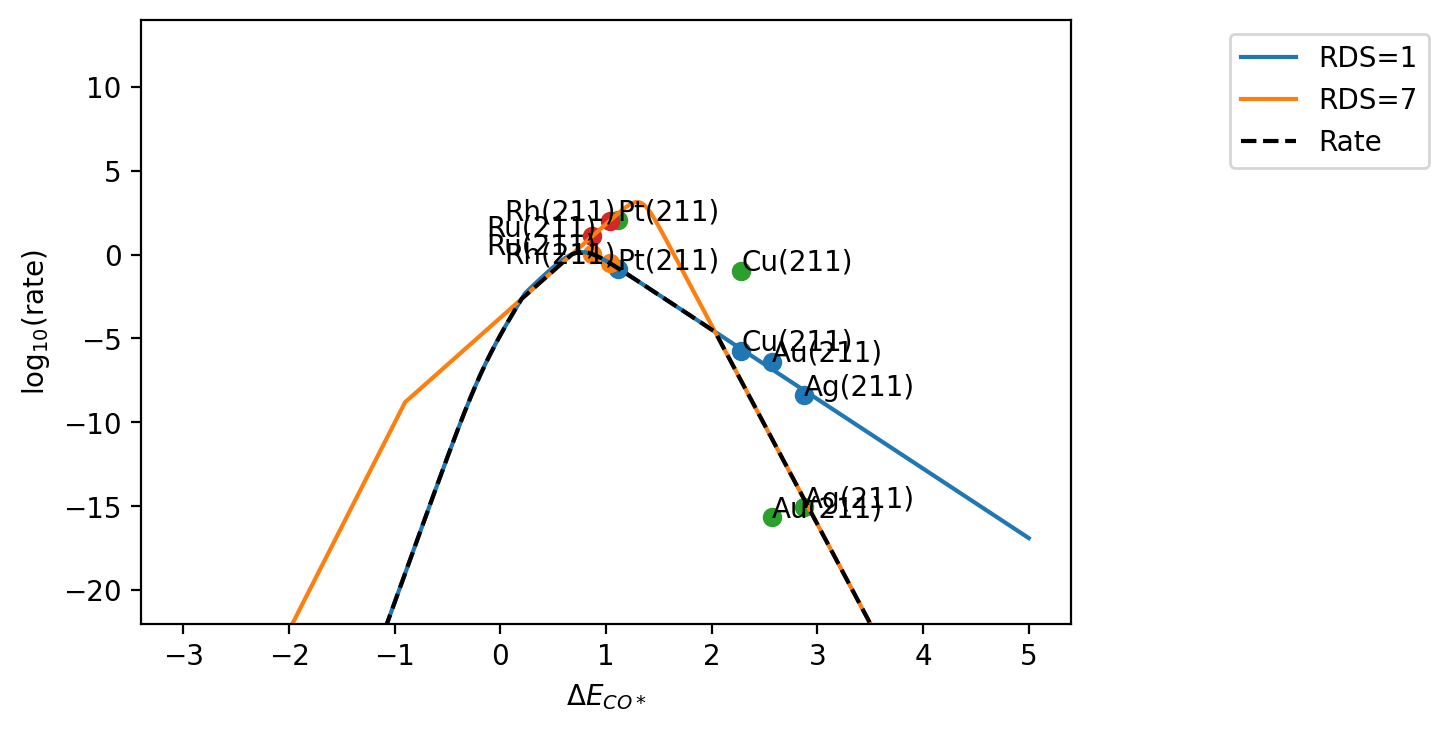

In [110]:
def get_CO(E_ch3_h):
    Eco = (E_ch3_h + 0.192)/0.822
    return Eco
pred_surf = ['Ru(211)', 'Rh(211)']
Ru_co = get_CO(E_ch3_h=0.52)
Rh_co = get_CO(E_ch3_h=0.66)

descriptor = np.array([Ru_co, Rh_co])
pd_free=free_energy_descriptor(descriptor,pd_scaling,energi_fixed,reactants,products_ts,products)
display(pd_free)

pred_rates=rates_descriptor(descriptor,pd_free,A,kBT,pressures_p,rates_list)
display(pred_rates)

# Plot the volcano
fig=plt.figure(dpi=200)
for r in rates_list.keys():
    plt.plot(pd_rates['Descriptor'],pd_rates['RDS'+r],label='RDS='+r)
    
    plt.scatter(pd_rates_surf['Descriptor'],pd_rates_surf['RDS'+r])
    for i, surf_txt in enumerate(pd_rates_surf['Surface']):
        plt.annotate(surf_txt, (pd_rates_surf['Descriptor'][i],pd_rates_surf['RDS'+r][i]))
        
    plt.scatter(pred_rates['Descriptor'],pred_rates['RDS'+r])
    for i, surf_txt in enumerate(pred_surf):
        plt.annotate(surf_txt, (pred_rates['Descriptor'][i]-1,pred_rates['RDS'+r][i]))
plt.plot(pd_rates['Descriptor'],pd_rates['R'],'k--',label='Rate')  

plt.ylabel('log$_{10}$(rate)')
plt.xlabel('$\Delta E_{CO*}$')
plt.legend(bbox_to_anchor=(1.4,1))
plt.ylim(-22,14)
plt.show()